In [234]:
import pandas as pd
import numpy as np
import sqlalchemy
import ast
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

In [719]:
%matplotlib notebook

In [722]:
matplotlib.rcParams.update({'font.size': 15})

In [6]:
from attU.sql import psql_load
from attU.dfclean import convert_dates

In [7]:
attune_dw_host = os.getenv('ATTUNE_DW_HOST')
attune_dw_user = os.getenv('ATTUNE_DW_USER')
attune_dw_db = os.getenv('ATTUNE_DW_DB', 'attune_dw')

### General Exploration

In [316]:
#get query type, channel and ticket count after 1/1/19
query = '''
select 
case when t.inquiry_type in ('about_attune','general_inquiries',
							 'general_inquiry','miscellaneous_na',
							 'technical_support','voicemails',
							 'commission_inquiries','binding_moratorium'
							 'intuit_support','claim_inquiries') then 'General'
when t.inquiry_type in ('coverage_inquiries','coverage_inquiries_','eligibility') then 'Coverage/Eligibility'
when t.inquiry_type in ('quote_changes') then 'Quote change'
when t.inquiry_type in ('bind_requests','policy_issuance','policy_issuance_') then 'Issuance'
when t.inquiry_type in ('endorsement_non_premium_bearing','endorsements') then 'Policy change'
when t.inquiry_type in ('agent_cancellation','cancellations') then 'Cancellation'
when t.inquiry_type in ('reinstatement_request') then 'Reinstatement'
when t.inquiry_type in ('renewal_indication','renewals') then 'Renewals'
when t.inquiry_type in ('billing_inquiries','collections') then 'Billing'
when t.inquiry_type in ('underwriting_audit') then 'UW Audit'
when t.inquiry_type in ('loss_runs','document_requests','document_requested') then 'Documents'
when t.inquiry_type in ('wc','workers_compensation') then 'Workers Comp'
else 'General' end as inquiry_type_cleaned,
via_channel, count(distinct(ticket_id)) num_ticket_id
from zendesk_tickets t
where date(t.created_at::timestamp)>'2018-12-31'
group by 1,2
order by 3 desc;
'''

In [337]:
df = psql_load(query)
df.head()

ticket_id                                               tags
0     98698  ['billing_center_change_paymentplan', 'billing...
1     57551  ['attune_insurance', 'billing_center_change_pa...
2     47269      ['billing_inquiries', 'payment_confirmation']
3    150805  ['attune_insurance', 'billing_inquiries', 'bil...
4    128007  ['billing_inquiries', 'reinstatement_approved'...

In [319]:
df.rename(columns={'inquiry_type_cleaned':'itype'}, inplace=True)

In [320]:
df.groupby('itype')['num_ticket_id'].sum().sort_values(ascending=False)

itype
General                 31194
Workers Comp            30894
Billing                 22551
Quote change            19054
Policy change           15398
Cancellation            13931
Coverage/Eligibility    13503
Renewals                 9073
Documents                7318
UW Audit                 3647
Issuance                 3292
Reinstatement             178
Name: num_ticket_id, dtype: int64

In [ ]:
df['pct_total'] = (df.num_ticket_id/df.num_ticket_id.sum()).round(2)
df['pct_c'] = df.pct_total.cumsum()

In [323]:
df.head(20)

itype via_channel  num_ticket_id  pct_total  pct_c
0           Workers Comp       email          16279       0.10   0.10
1           Quote change        chat          11455       0.07   0.17
2          Policy change       email          11255       0.07   0.24
3           Workers Comp         web          11105       0.07   0.31
4   Coverage/Eligibility        chat          10048       0.06   0.37
5                Billing       voice          10001       0.06   0.43
6                General        chat           9315       0.05   0.48
7           Cancellation         web           9135       0.05   0.53
8               Renewals         web           8190       0.05   0.58
9                General       voice           7759       0.05   0.63
10               Billing       email           7345       0.04   0.67
11               General       email           6898       0.04   0.71
12          Quote change       email           5057       0.03   0.74
13               General         web           3832       0.02   0.76
14          Cancellation       email           3500       0.02   0.78
15               Billing        chat           3489       0.02   0.80
16               General         api           3390       0.02   0.82
17             Documents       email           2928       0.02   0.84
18              Issuance       email           2800       0.02   0.86
19              UW Audit         api           2673       0.02   0.88

In [322]:
df[df.itype=='Billing'].iloc[:,1:3]

via_channel  num_ticket_id
5        voice          10001
10       email           7345
15        chat           3489
24         web           1715
55         api              1

- First 14 rows cover 75% of tickets, mostly chat and email
- voice Billings are 6th by inquiry-chanell and billings are 3rd overall
- Start with email & chat (6% of all tickets), definitely need voice.

### Billings tags

In [551]:
query = '''
select t.ticket_id, t.tags
from zendesk_tickets t
where t.inquiry_type in ('billing_inquiries','collections')
and date(t.created_at::timestamp)>'2018-12-31';
'''

In [552]:
tdf = psql_load(query)

In [553]:
tdf.head()

ticket_id                                               tags
0    136256  ['billing_center_change_paymentplan', 'billing...
1     98698  ['billing_center_change_paymentplan', 'billing...
2     57551  ['attune_insurance', 'billing_center_change_pa...
3     47269      ['billing_inquiries', 'payment_confirmation']
4    150805  ['attune_insurance', 'billing_inquiries', 'bil...

In [554]:
tdf['tags'] = tdf.tags.map(lambda x: ast.literal_eval(x))

In [555]:
#most used tags
tcounts = pd.Series(np.hstack(tdf.tags.values)).value_counts()

In [556]:
tcounts

billing_inquiries                                                22638
t1_ticket                                                        11216
tier_1                                                           10962
inbound_call                                                      8077
payment_confirmation                                              5005
billing_process                                                   3628
zopim_chat                                                        3507
zopim_chat_ended                                                  3498
attune_insurance                                                  3135
billing_center_change_paymentplan                                 2181
billing_center_instructions                                       1989
t2_ticket                                                         1775
updaed_insured_email                                              1635
vip                                                               1624
tier_2

In [557]:
dbtags = tcounts[tcounts>5][1:]

In [1]:
#sell tags of interest
raw = '''payment_confirmation	341
payment_history_schedule_request	262
collections	259
billing_process	252
commission_inquiries	234
billing_center_change_paymentplan	156
invoice_request	156
updaed_insured_email	133
no_known_loss_requested	129
stripe_unenroll_autopay	103
refund_process	86
commission_inquiry	84
q4incentive	84
billing_center_instructions	83
check_request	82
automatic_payment_status	70
stripe_change_paymentmethod	65
automatic_payment_instructions	43
reinstatement_approved	38
commission_statement	30
billing_center_update_downpayment	29
update_agent_email	19
update_commission_account	15
change_email	14
renewal_indication	14
renewal_issuance	13
2_4_pay_inquiry	12
bop	11
cancellation_confirmation	11
payment_viaphone_request	10
policy_issuance_	10
policy_issuance_request	10
siaa	10
broker_cancel_request	9
check_confirmation	9
'''

In [2]:
sell_tags = raw.replace('\t',' ').replace('\n',' ').split()[::2]

In [3]:
len(sell_tags)

35

In [5]:
sorted(sell_tags)

['2_4_pay_inquiry',
 'automatic_payment_instructions',
 'automatic_payment_status',
 'billing_center_change_paymentplan',
 'billing_center_instructions',
 'billing_center_update_downpayment',
 'billing_process',
 'bop',
 'broker_cancel_request',
 'cancellation_confirmation',
 'change_email',
 'check_confirmation',
 'check_request',
 'collections',
 'commission_inquiries',
 'commission_inquiry',
 'commission_statement',
 'invoice_request',
 'no_known_loss_requested',
 'payment_confirmation',
 'payment_history_schedule_request',
 'payment_viaphone_request',
 'policy_issuance_',
 'policy_issuance_request',
 'q4incentive',
 'refund_process',
 'reinstatement_approved',
 'renewal_indication',
 'renewal_issuance',
 'siaa',
 'stripe_change_paymentmethod',
 'stripe_unenroll_autopay',
 'updaed_insured_email',
 'update_agent_email',
 'update_commission_account']

In [558]:
dbtags[~dbtags.index.isin(sell_tags)]

t1_ticket                                            11216
tier_1                                               10962
inbound_call                                          8077
zopim_chat                                            3507
zopim_chat_ended                                      3498
attune_insurance                                      3135
t2_ticket                                             1775
vip                                                   1624
tier_2                                                1509
outbound_email                                        1334
outbound_call                                         1229
outbound_to_voicemail                                 1032
retention_project                                     1017
document_requested                                     926
voicemail                                              773
answer_bot                                             510
ccc_email                                              4

In [559]:
def check_tag_overlap(row, check_tag_list):
    input_tag_list = row['tags']
    overlap = set(input_tag_list).intersection(check_tag_list)
    if overlap:
        out_dict = {}
        for t in overlap:
            out_dict.update({'ticket_id': row['ticket_id'], "tag": t})
        return out_dict
    return None

In [560]:
tdicts = tdf.apply(lambda x: check_tag_overlap(x,sell_tags),axis=1)

In [562]:
tdicts.isnull().value_counts()/tdicts.isnull().value_counts().sum()

False    0.871013
True     0.128987
dtype: float64

13% without sell tags

In [563]:
tags_exploded = pd.DataFrame.from_records(tdicts.dropna().values)

In [564]:
tags_exploded.head()

tag ticket_id
0  billing_center_change_paymentplan    136256
1  billing_center_change_paymentplan     98698
2  billing_center_change_paymentplan     57551
3               payment_confirmation     47269
4                    billing_process    150805

In [424]:
#get tid, date after 1/1/19
query = '''
select date(created_at::timestamp) date, ticket_id
from zendesk_tickets
where inquiry_type in ('billing_inquiries', 'collections')
and date(created_at::timestamp)>'2018-12-31'
'''

In [425]:
btdf = psql_load(query)

In [565]:
# join bt and tags
btt = btdf.merge(tags_exploded, how='left', on='ticket_id').sort_values(
    'date', ascending=True).replace({np.nan: None}).reset_index(drop=True)

In [566]:
btt.ticket_id.unique().size

22638

In [567]:
btt.count()

date         22638
ticket_id    22638
tag          19718
dtype: int64

In [568]:
btt.groupby('ticket_id')['tag'].count().value_counts()

1    19718
0     2920
Name: tag, dtype: int64

Interestingly, all billings tickets have at most 1 tag of interest

In [569]:
btt.replace({None:'NO TAG'}, inplace=True)

In [570]:
missing  = set(sell_tags).difference(btt.tag.unique())
missing

{'commission_inquiries',
 'commission_statement',
 'q4incentive',
 'update_commission_account'}

In [571]:
plotdf = btt.groupby(['date', 'tag']).count().reset_index().rename(columns={'ticket_id':'num_tickets'})

In [572]:
plotdf.head()

date                                tag  num_tickets
0  2019-01-02                             NO TAG           10
1  2019-01-02  billing_center_change_paymentplan            6
2  2019-01-02        billing_center_instructions           20
3  2019-01-02  billing_center_update_downpayment            2
4  2019-01-02                    billing_process           10

Investigate 'NO TAG' database tags

In [582]:
btt[btt.tag=='NO TAG'].ticket_id.unique().size

2920

Top tags for ticket IDs with tags NOT in list of interest

In [586]:
pd.Series(np.hstack(tdf[tdf.ticket_id.isin(
    btt[btt.tag == 'NO TAG'].ticket_id.unique())].tags.values)).value_counts()

billing_inquiries                  2920
t1_ticket                          1094
tier_1                             1027
inbound_call                        788
t2_ticket                           569
tier_2                              562
zopim_chat                          366
zopim_chat_ended                    365
attune_insurance                    329
outbound_email                      226
vip                                 225
reinstatement_payment_update        136
voicemail                           126
billing_center_unable_to_login      125
answer_bot                           94
ccc_email                            89
outbound_call                        80
rescission_notice                    66
ratingbug_refund                     57
appalachian_underwriters__inc        49
endorsement_non_premium_bearing      48
1099                                 39
escalation                           38
web_widget                           37
change_effective_date                37


<IPython.core.display.Javascript object>


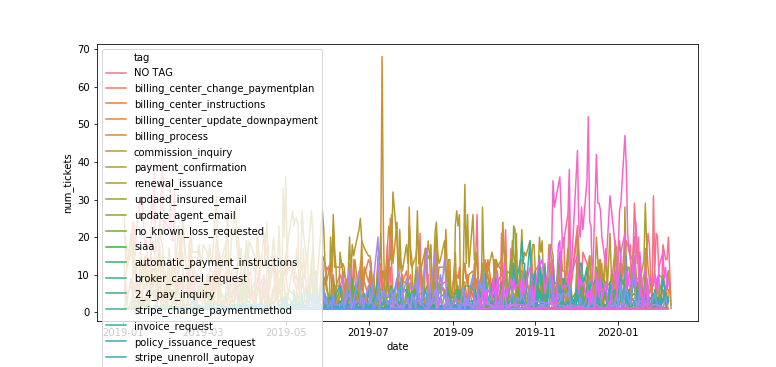

In [686]:
#timeseries, multiple, seaborn
fig,ax = plt.subplots()

sns.lineplot(x="date", y="num_tickets",
             hue="tag",
             data=plotdf,
             ax=ax)

### Billings tags & active policies

In [518]:
query = '''
select date(transaction_date::timestamp) pdate, count(distinct(policy_number)) num_active_policies
from premium_losses
where status = 'active'
and date(transaction_date::timestamp)>'2018-12-31'
group by 1
'''

In [519]:
pdf = psql_load(query)

In [520]:
pdf.head()

pdate  num_active_policies
0  2019-01-01                 6982
1  2019-01-02                 7010
2  2019-01-03                 7043
3  2019-01-04                 7075
4  2019-01-05                 7087

In [587]:
plotdf.head()

date                                tag  num_tickets
0  2019-01-02                             NO TAG           10
1  2019-01-02  billing_center_change_paymentplan            6
2  2019-01-02        billing_center_instructions           20
3  2019-01-02  billing_center_update_downpayment            2
4  2019-01-02                    billing_process           10

In [588]:
plot_ttp = plotdf.merge(pdf, how='left',left_on='date', right_on='pdate')

In [589]:
plot_ttp['normed'] = plot_ttp.num_tickets/plot_ttp.num_active_policies

In [590]:
plot_ttp.head()

date                                tag  num_tickets       pdate  \
0  2019-01-02                             NO TAG           10  2019-01-02   
1  2019-01-02  billing_center_change_paymentplan            6  2019-01-02   
2  2019-01-02        billing_center_instructions           20  2019-01-02   
3  2019-01-02  billing_center_update_downpayment            2  2019-01-02   
4  2019-01-02                    billing_process           10  2019-01-02   

   num_active_policies    normed  
0                 7010  0.001427  
1                 7010  0.000856  
2                 7010  0.002853  
3                 7010  0.000285  
4                 7010  0.001427

In [620]:
#get tag order (normed)
plot_ttp.groupby('tag')['normed'].sum().sort_values(ascending=False)[:12]

tag
payment_confirmation                 0.304498
billing_process                      0.240991
NO TAG                               0.212173
billing_center_change_paymentplan    0.142589
billing_center_instructions          0.138731
updaed_insured_email                 0.108786
stripe_unenroll_autopay              0.039532
collections                          0.037506
no_known_loss_requested              0.034341
payment_history_schedule_request     0.031126
update_agent_email                   0.030983
invoice_request                      0.030334
Name: normed, dtype: float64

In [621]:
#get tag order
# (plot_ttp.groupby('tag')['num_tickets'].sum().sort_values(ascending=False).cumsum()/22638)[:11]

In [751]:
#map tags for plot legend
TOP_N = 11
tag_order = plot_ttp.groupby('tag')['normed'].sum().sort_values(ascending=False).index.values.tolist()
legend_names = tag_order[:TOP_N]
legend_names.append('Other')

In [752]:
tag_names = [t.replace('_',' ') for t in legend_names]

In [638]:
plot_ttp['tag_name'] = plot_ttp.tag.map(lambda x: x.replace('_',' ') if x in legend_names else 'Other')

In [639]:
plot_ttp.head(10)

date                                tag  num_tickets       pdate  \
0  2019-01-02                             NO TAG           10  2019-01-02   
1  2019-01-02  billing_center_change_paymentplan            6  2019-01-02   
2  2019-01-02        billing_center_instructions           20  2019-01-02   
3  2019-01-02  billing_center_update_downpayment            2  2019-01-02   
4  2019-01-02                    billing_process           10  2019-01-02   
5  2019-01-02                 commission_inquiry            1  2019-01-02   
6  2019-01-02               payment_confirmation           26  2019-01-02   
7  2019-01-02                   renewal_issuance            1  2019-01-02   
8  2019-01-02               updaed_insured_email           13  2019-01-02   
9  2019-01-02                 update_agent_email            1  2019-01-02   

   num_active_policies    normed                           tag_name  
0                 7010  0.001427                             NO TAG  
1                 7010  0.000856  billing center change paymentplan  
2                 7010  0.002853        billing center instructions  
3                 7010  0.000285                              Other  
4                 7010  0.001427                    billing process  
5                 7010  0.000143                              Other  
6                 7010  0.003709               payment confirmation  
7                 7010  0.000143                              Other  
8                 7010  0.001854               updaed insured email  
9                 7010  0.000143                 update agent email

<IPython.core.display.Javascript object>


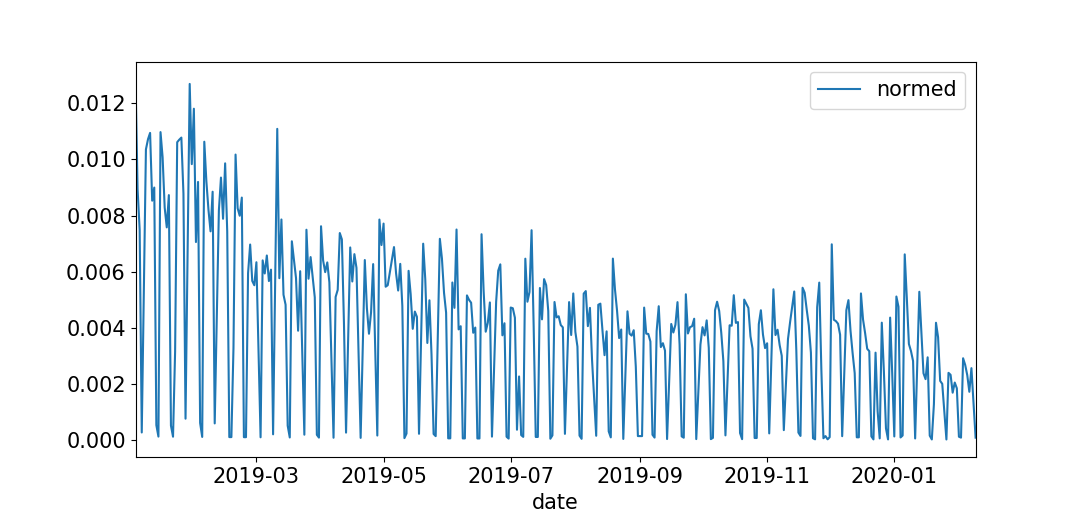

In [647]:
plot_ttp.groupby('date')['normed'].sum().reset_index().plot('date','normed')

In [665]:
# #timeseries, multiple, seaborn
# fig,ax = plt.subplots()

# sns.lineplot(x="date", y="normed",
#              hue="tag_name",
#              data=plot_ttp,
#              hue_order=legend_names,
#              ax=ax)

In [653]:
plot_ttp['date'] = pd.to_datetime(plot_ttp.date)

In [666]:
plot_ttp.head()

date                                tag  num_tickets       pdate  \
0 2019-01-02                             NO TAG           10  2019-01-02   
1 2019-01-02  billing_center_change_paymentplan            6  2019-01-02   
2 2019-01-02        billing_center_instructions           20  2019-01-02   
3 2019-01-02  billing_center_update_downpayment            2  2019-01-02   
4 2019-01-02                    billing_process           10  2019-01-02   

   num_active_policies    normed                           tag_name  
0                 7010  0.001427                             NO TAG  
1                 7010  0.000856  billing center change paymentplan  
2                 7010  0.002853        billing center instructions  
3                 7010  0.000285                              Other  
4                 7010  0.001427                    billing process

In [714]:
resampled = plot_ttp.set_index('date').groupby([pd.Grouper(freq='w'), 'tag_name'])[
    'normed'].sum().unstack('tag_name').fillna(0)
resampled.head()

tag_name      NO TAG     Other  billing center change paymentplan  \
date                                                                
2019-01-06  0.003269  0.000854                           0.002416   
2019-01-13  0.010201  0.001649                           0.003728   
2019-01-20  0.016615  0.001609                           0.002138   
2019-01-27  0.014982  0.001692                           0.003254   
2019-02-03  0.017992  0.001521                           0.003790   

tag_name    billing center instructions  billing process  collections  \
date                                                                    
2019-01-06                     0.007389         0.004542          0.0   
2019-01-13                     0.010250         0.010809          0.0   
2019-01-20                     0.007875         0.008698          0.0   
2019-01-27                     0.009377         0.005863          0.0   
2019-02-03                     0.005952         0.007613          0.0   

tag_name    no known loss requested  payment confirmation  \
date                                                        
2019-01-06                 0.000141              0.008100   
2019-01-13                 0.000276              0.008739   
2019-01-20                 0.000000              0.006829   
2019-01-27                 0.000000              0.005985   
2019-02-03                 0.000000              0.010791   

tag_name    payment history schedule request  stripe unenroll autopay  \
date                                                                    
2019-01-06                               0.0                      0.0   
2019-01-13                               0.0                      0.0   
2019-01-20                               0.0                      0.0   
2019-01-27                               0.0                      0.0   
2019-02-03                               0.0                      0.0   

tag_name    updaed insured email  update agent email  
date                                                  
2019-01-06              0.002562            0.000284  
2019-01-13              0.003335            0.001247  
2019-01-20              0.001876            0.000674  
2019-01-27              0.003130            0.000523  
2019-02-03              0.003293            0.000376

<IPython.core.display.Javascript object>


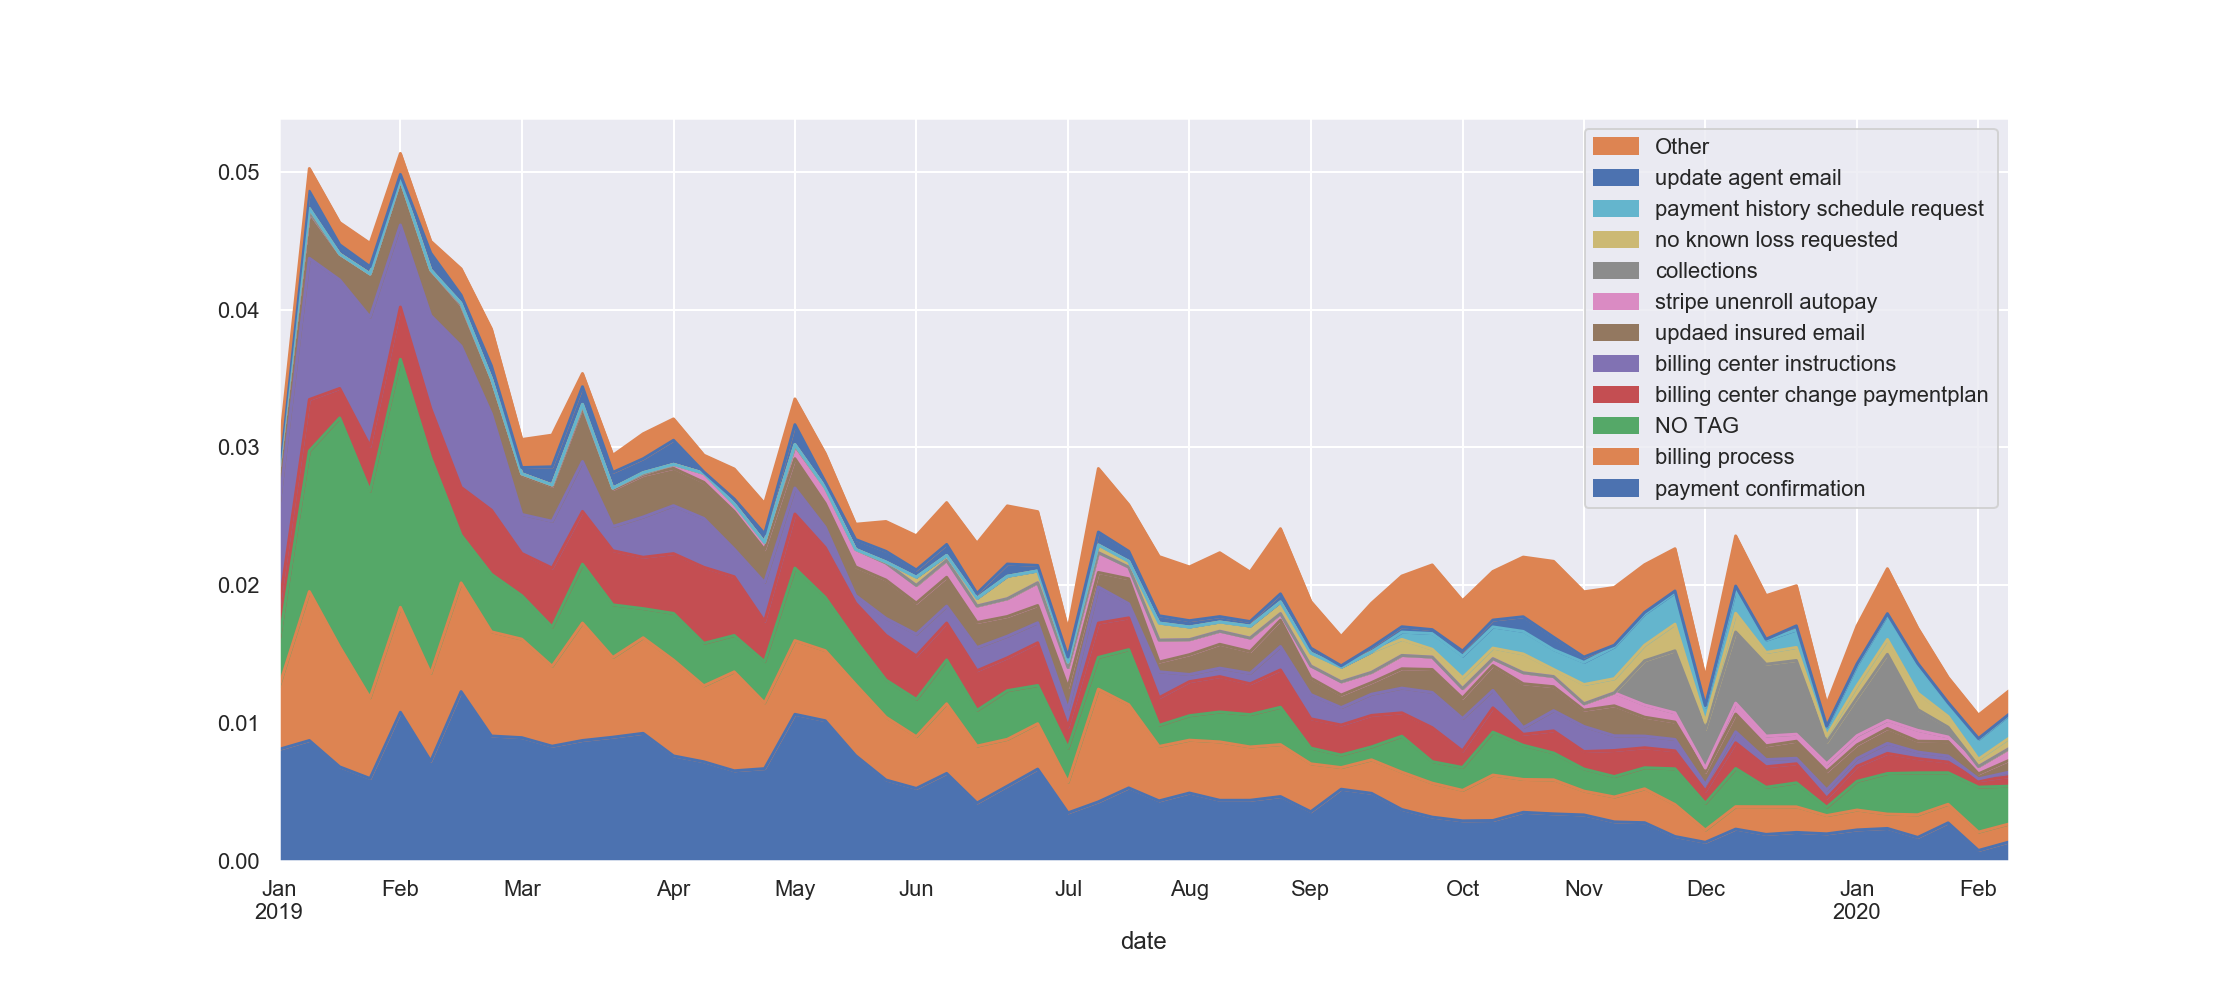

In [758]:
sns.set()
#change column order
ax = resampled[tag_names].plot(kind='area', stacked=True)
#colors
#dates
#yaxis num tickets/active policy or percentage


# Matplotlib idiom to reverse legend entries 
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

# Set x-axis major ticks to weekly interval, on Mondays
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));

In [762]:
resampled['total'] = resampled.sum(axis=1)

<IPython.core.display.Javascript object>


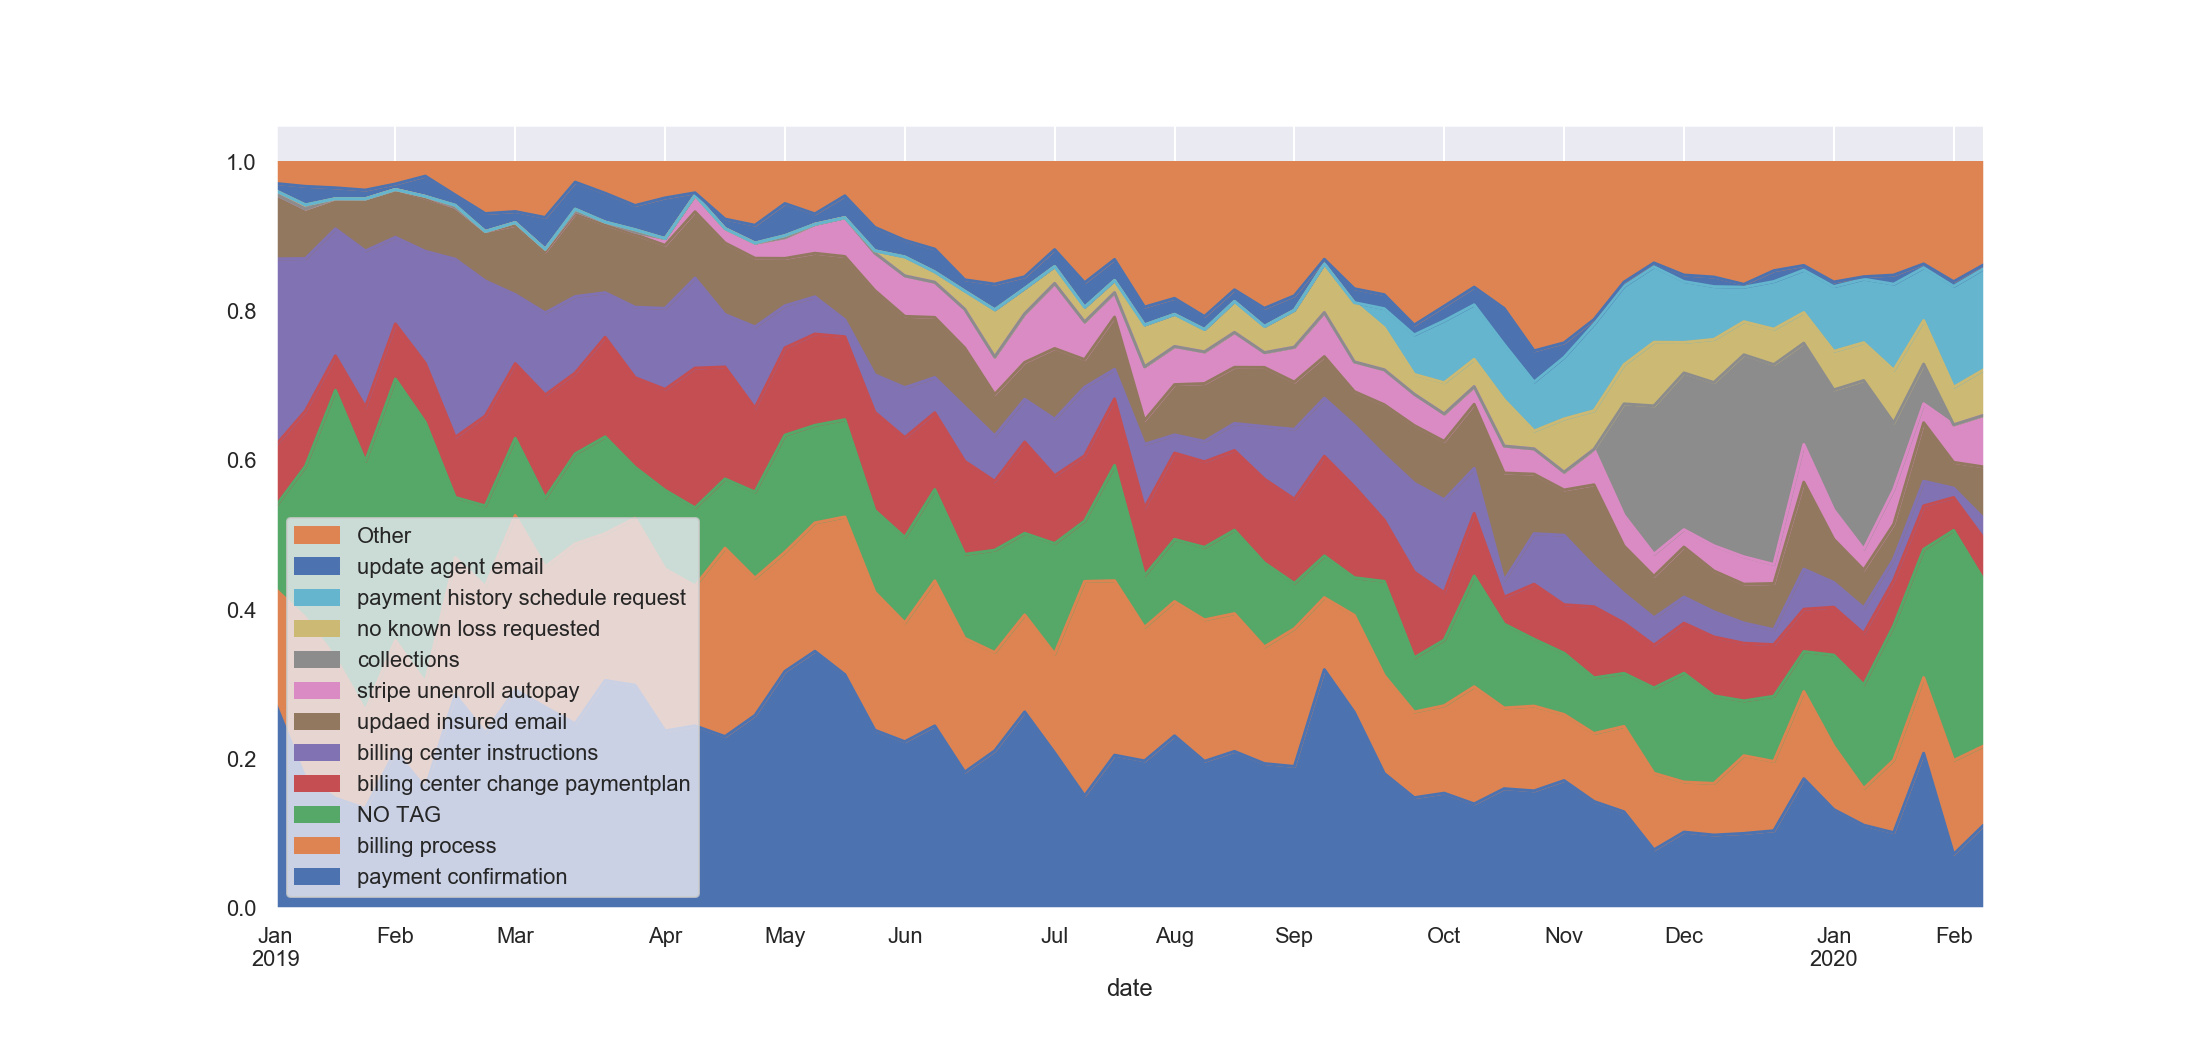

In [768]:
sns.set()
#change column order
ax = resampled.apply(lambda x: x/x.total, axis=1)[tag_names].plot(kind='area', stacked=True)
#colors
#dates
#yaxis num tickets/active policy or percentage


# Matplotlib idiom to reverse legend entries 
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='lower left')

# Set x-axis major ticks to weekly interval, on Mondays
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));

<IPython.core.display.Javascript object>


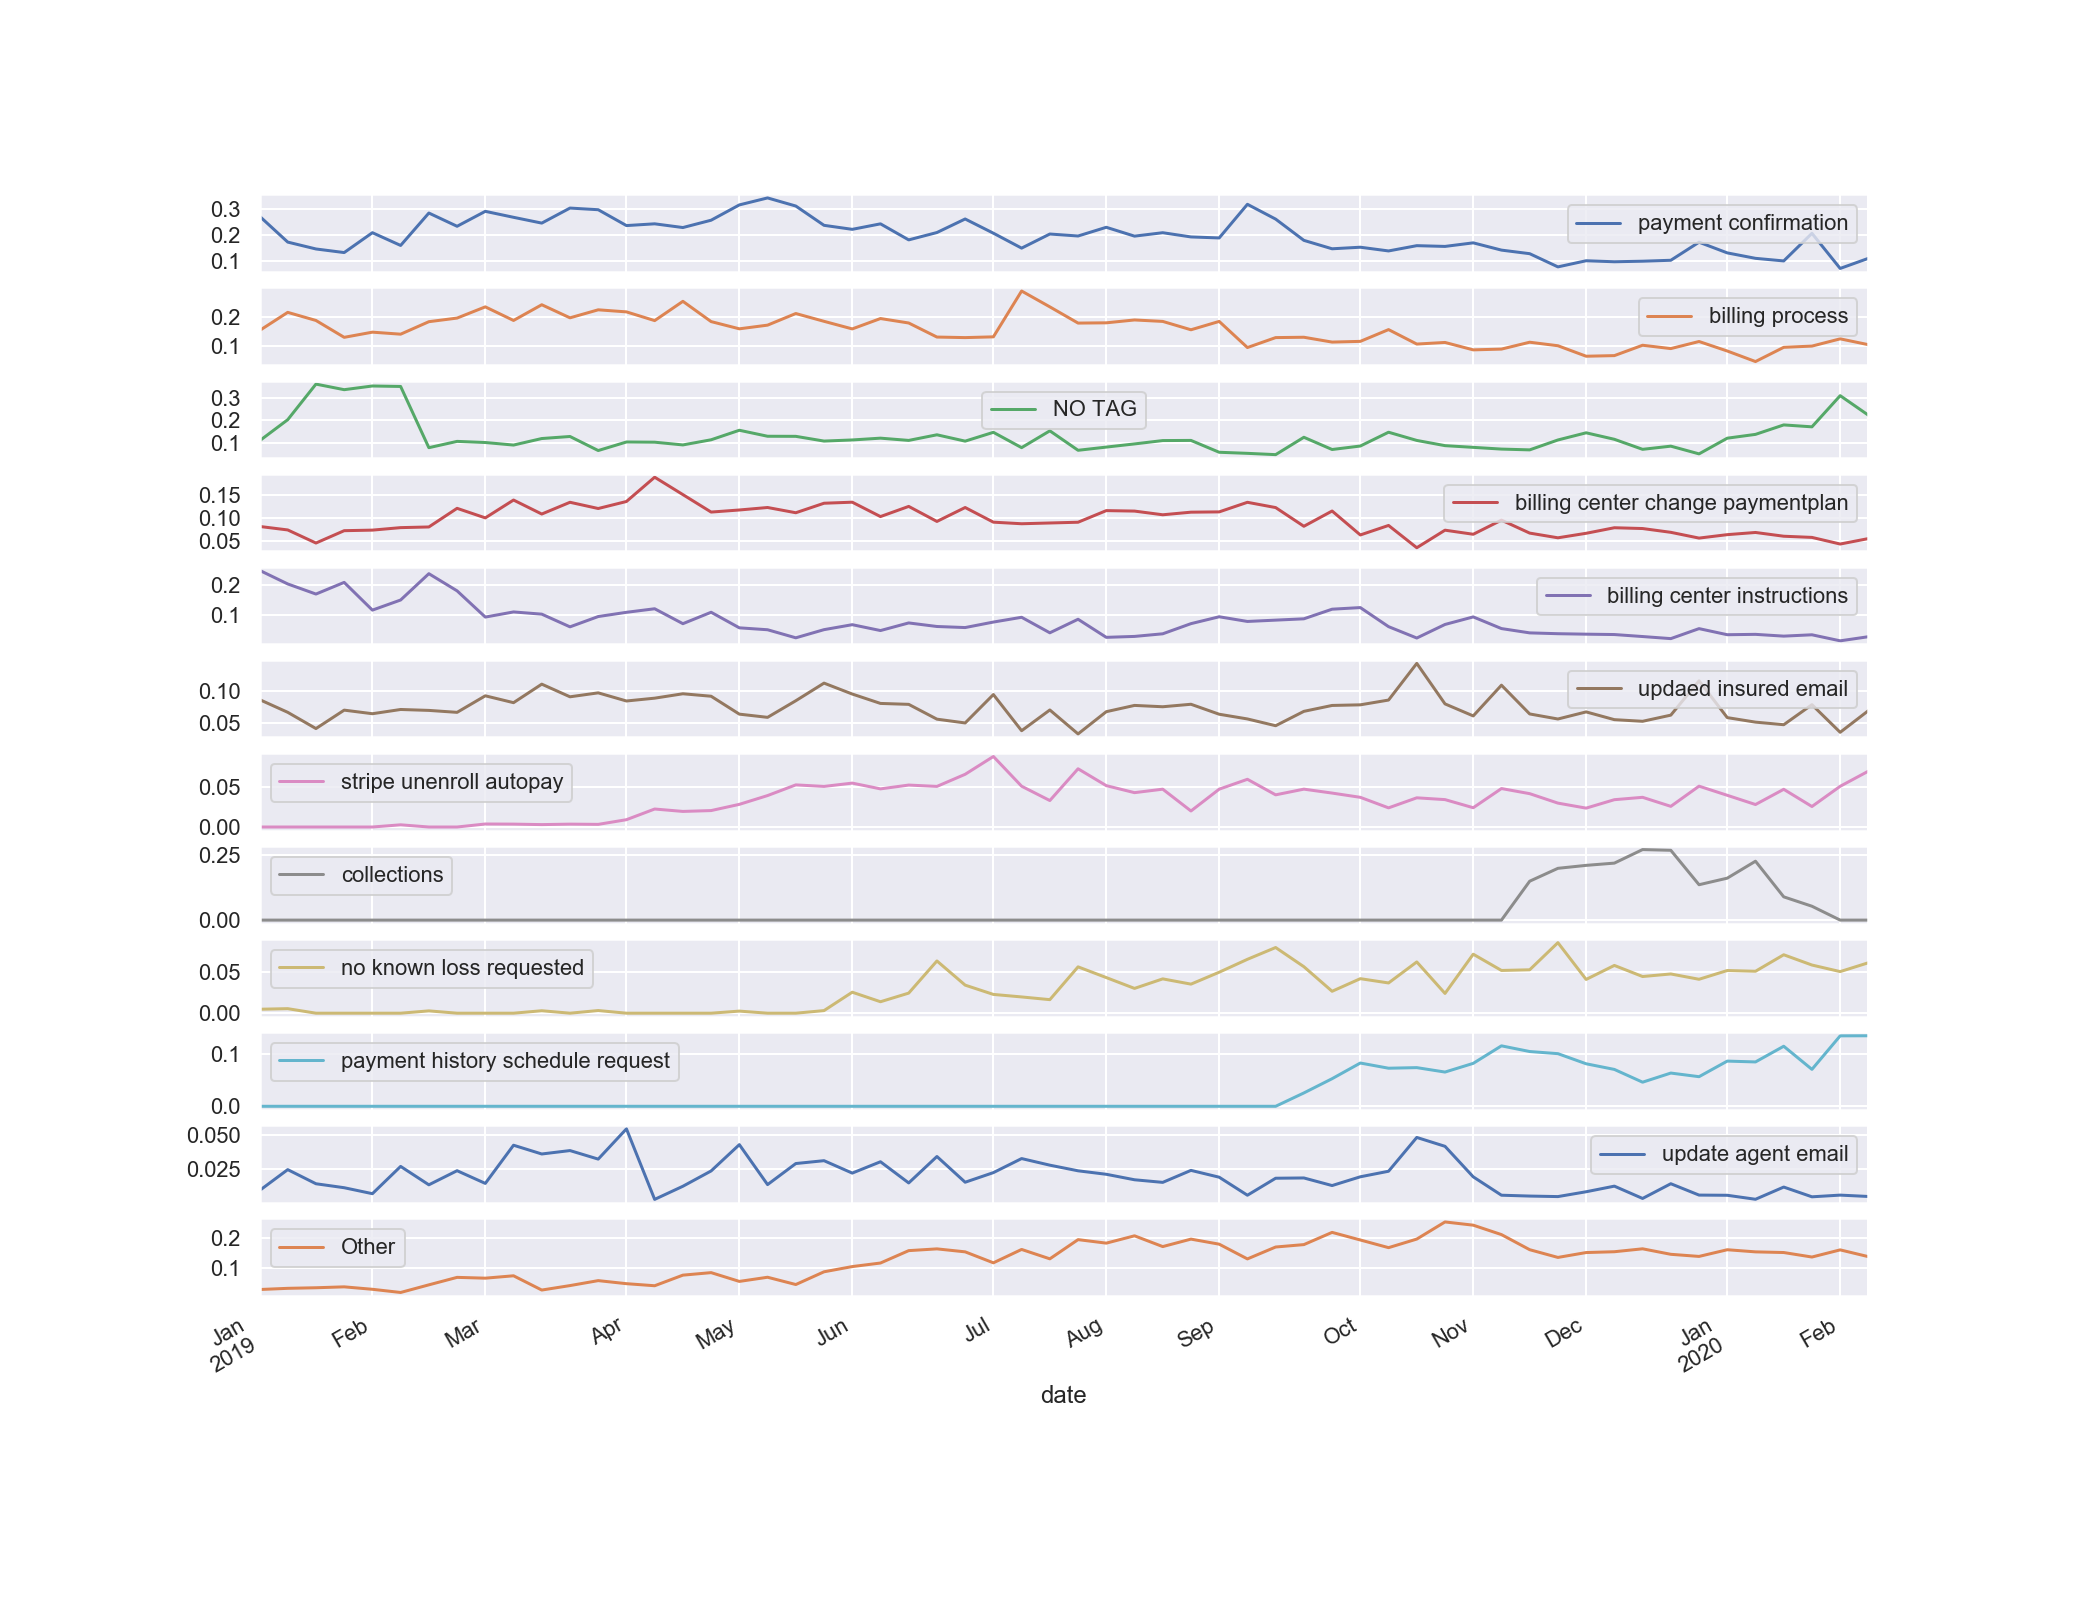

In [774]:
sns.set()
#change column order
ax = resampled.apply(lambda x: x/x.total, axis=1)[tag_names].plot(kind='line', stacked=False, subplots=True)
#colors
#dates
#yaxis num tickets/active policy or percentage


# Matplotlib idiom to reverse legend entries 
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(reversed(handles), reversed(labels), loc='lower left')

# Set x-axis major ticks to weekly interval, on Mondays
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));

### Billings & polices old

In [775]:
query = '''
with b as (
    select date(created_at::timestamp) bdate, count(distinct(ticket_id)) num_billings_tickets
    from zendesk_tickets
    where inquiry_type in ('billing_inquiries', 'collections')
    and date(created_at::timestamp)>'2018-12-31'
    group by 1
), p as (
    select date(transaction_date::timestamp) pdate, count(distinct(policy_number)) num_active_policies
    from premium_losses
    where status = 'active'
    and date(transaction_date::timestamp)>'2018-12-31'
    group by 1
)

select *
from p
full outer join b
on p.pdate = b.bdate;
'''

In [776]:
numbp = psql_load(query)

In [777]:
numbp.head()

pdate  num_active_policies       bdate  num_billings_tickets
0  2019-01-01                 6982        None                   NaN
1  2019-01-02                 7010  2019-01-02                  90.0
2  2019-01-03                 7043  2019-01-03                  63.0
3  2019-01-04                 7075  2019-01-04                  53.0
4  2019-01-05                 7087  2019-01-05                   2.0

In [783]:
numbp.drop('bdate',axis=1, inplace=True)
numbp.rename(columns={'pdate':'date'}, inplace=True)

In [785]:
numbp = numbp.set_index('date').fillna(0)

In [787]:
numbp.reset_index(inplace=True)

In [788]:
numbp.head()

date  num_active_policies  num_billings_tickets
0  2019-01-01                 6982                   0.0
1  2019-01-02                 7010                  90.0
2  2019-01-03                 7043                  63.0
3  2019-01-04                 7075                  53.0
4  2019-01-05                 7087                   2.0

Get column of new policies per day via diff

In [128]:
# df['num_new_active_policies'] = df.num_active_policies.diff().fillna(0)
# df['num_new_active_policies'] = df.num_new_active_policies.map(lambda x: x if x>=0 else 0)
# df.rename(columns={'num_billings_tickets':'num_billings_tickets_created'}, inplace=True)

Plotting

In [790]:
numbp['bill_norm_active'] = numbp.num_billings_tickets/numbp.num_active_policies

In [792]:
numbp.head()

date  num_active_policies  num_billings_tickets  bill_norm_active
0  2019-01-01                 6982                   0.0          0.000000
1  2019-01-02                 7010                  90.0          0.012839
2  2019-01-03                 7043                  63.0          0.008945
3  2019-01-04                 7075                  53.0          0.007491
4  2019-01-05                 7087                   2.0          0.000282

In [793]:
numbp.to_csv('billings_policies_2020-02-11.csv', index=False)

<IPython.core.display.Javascript object>


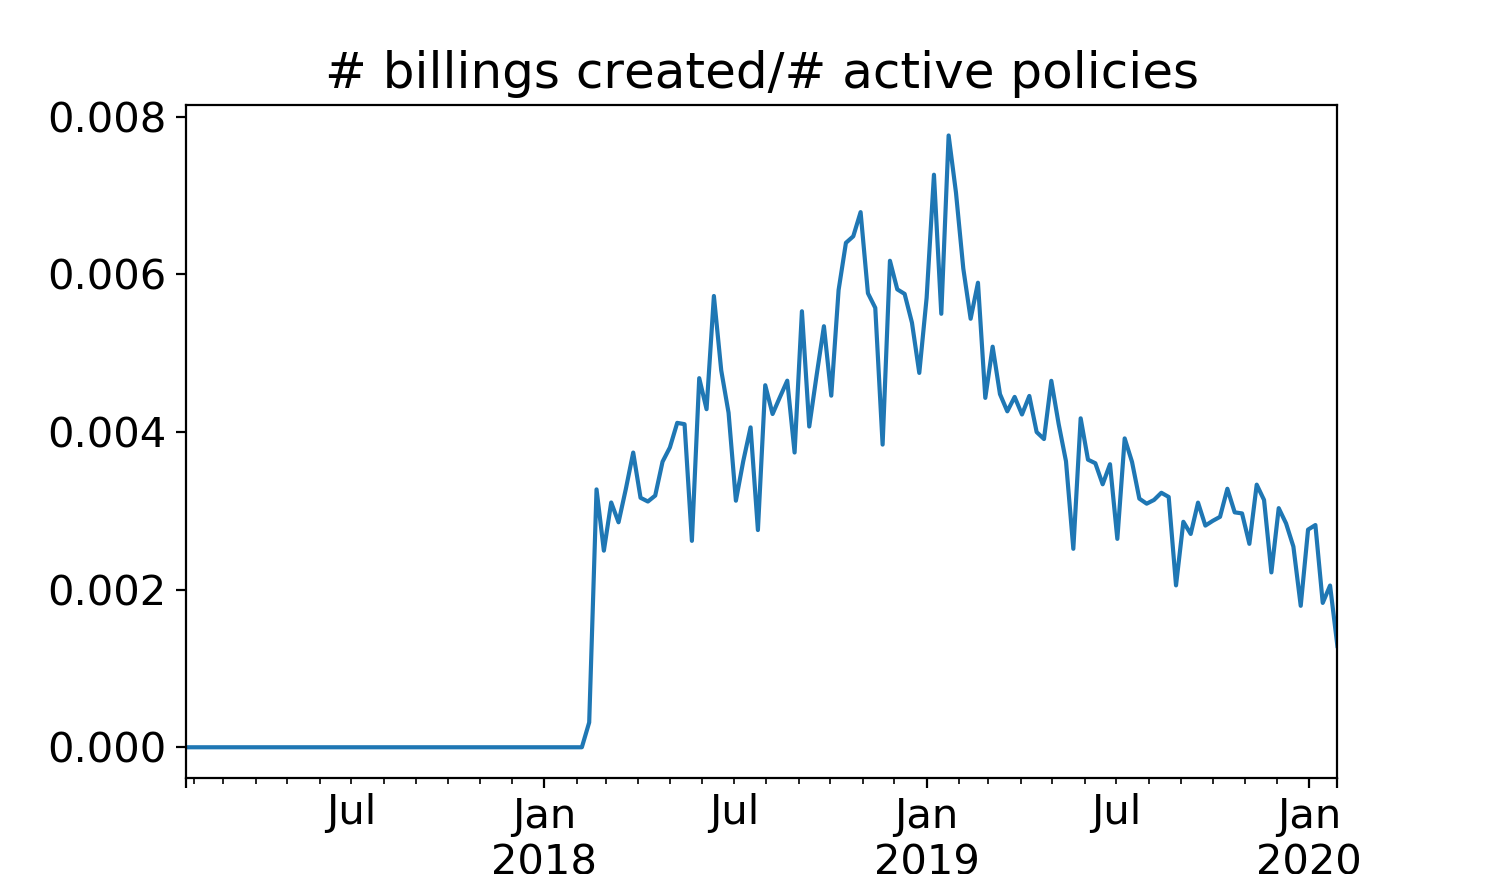

In [175]:
df.set_index('date').resample('7d').mean()['bill_norm_active'].plot(title='# billings created/# active policies')

In [148]:
dfm = df.set_index('date').resample('7d').sum().drop('num_active_policies', axis=1).\
    reset_index().melt(id_vars='date', value_vars=[
        'num_new_billings_tickets', 'num_new_active_policies'])

<IPython.core.display.Javascript object>


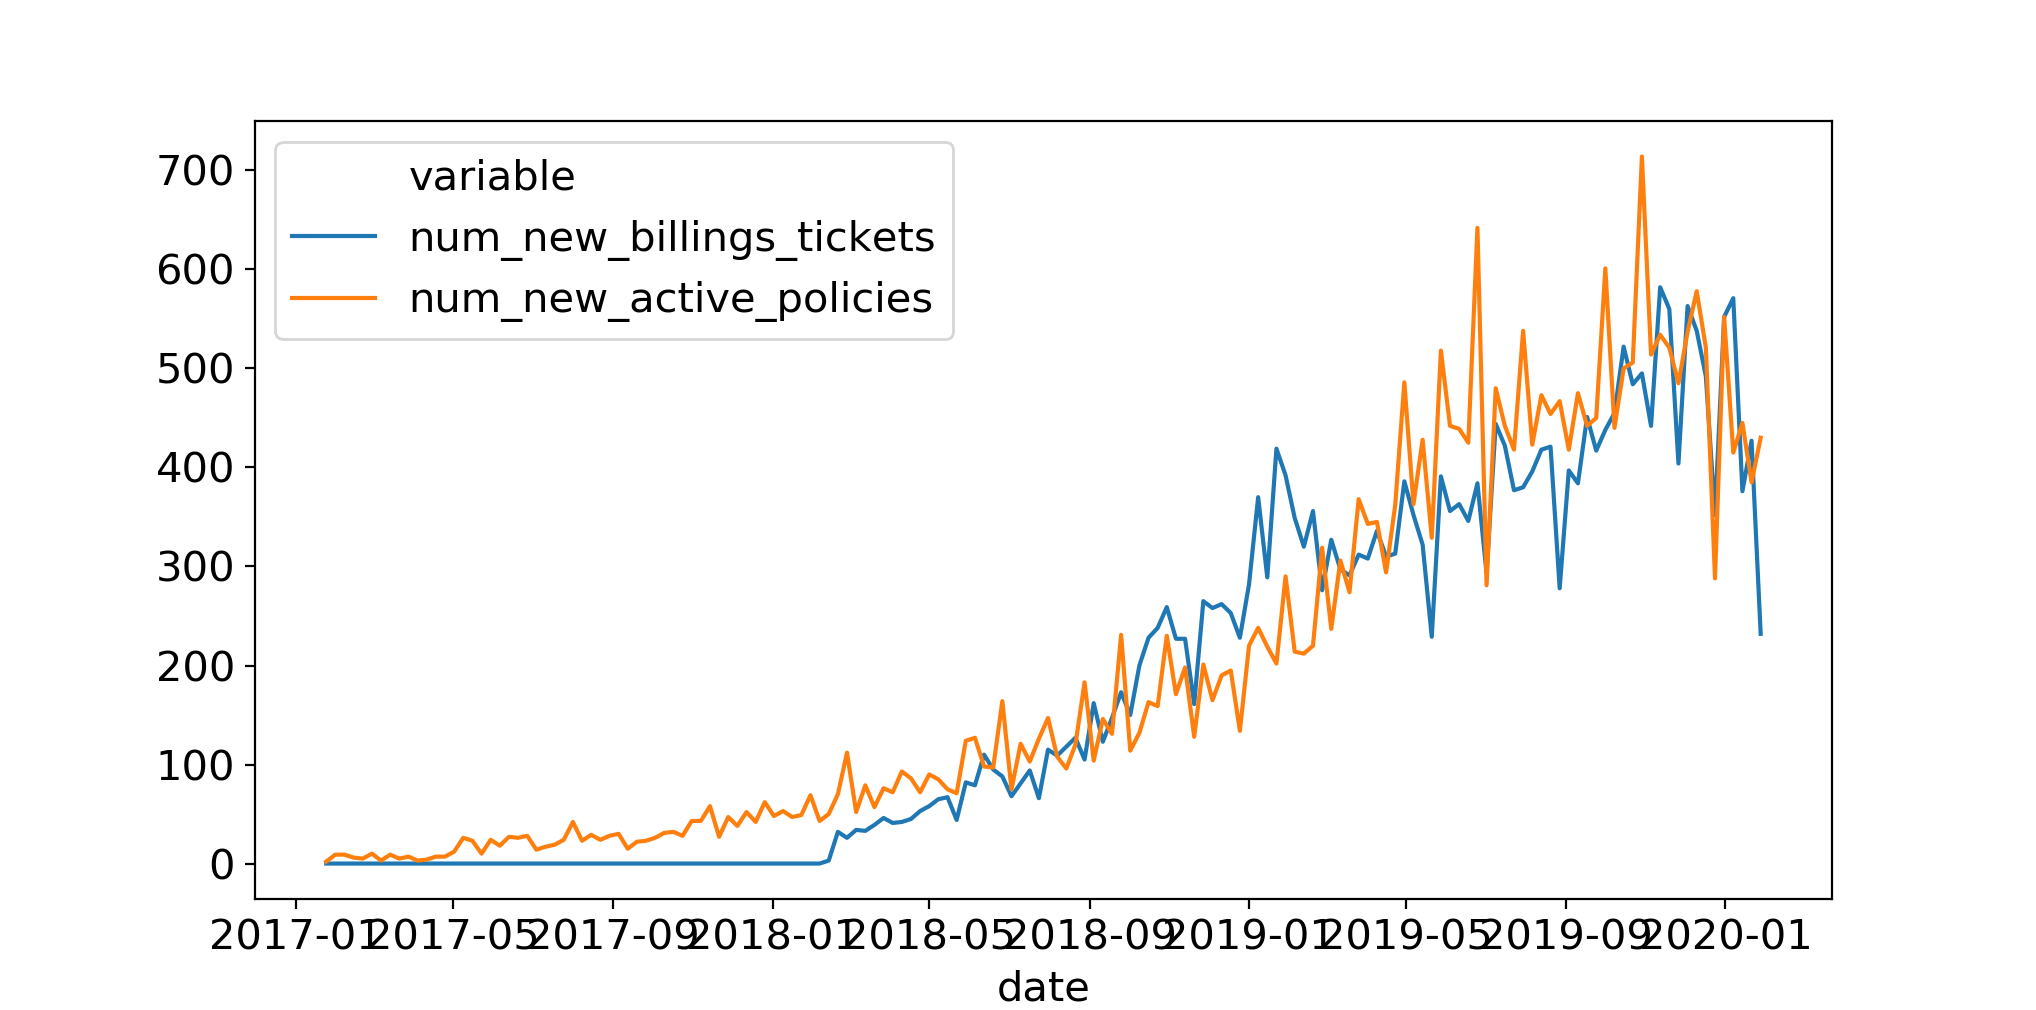

Text(0, 0.5, '')

In [149]:
ax = sns.lineplot(x="date", y="value",
             hue="variable",
             data=dfm)
ax.set_ylabel('')

### Billings tickets over monthly binds

In [833]:
df = pd.read_csv('../requests/billings_tickets_over_binds30_new.csv')

In [834]:
df['ticket_date'] = pd.to_datetime(df.ticket_date)

In [836]:
df.head()

ticket_date  num_tickets  num_binds  binds30  tickets_over_binds30
0  2018-02-16            1       11.0    298.0              0.003356
1  2018-02-19            2        7.0    282.0              0.007092
2  2018-02-20            7       11.0    293.0              0.023891
3  2018-02-21            3       26.0    304.0              0.009868
4  2018-02-22           13       25.0    308.0              0.042208

<IPython.core.display.Javascript object>


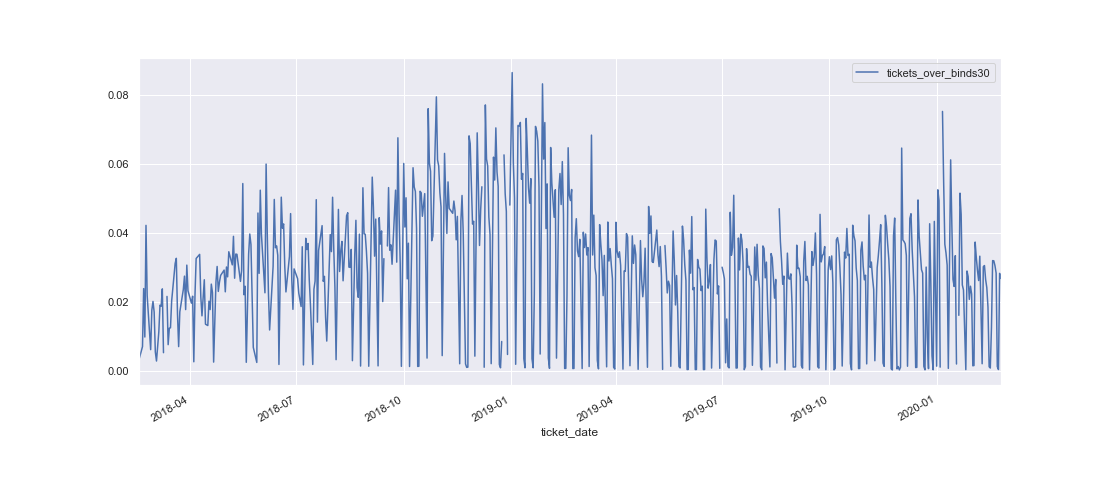

In [837]:
df.plot('ticket_date','tickets_over_binds30')

<IPython.core.display.Javascript object>


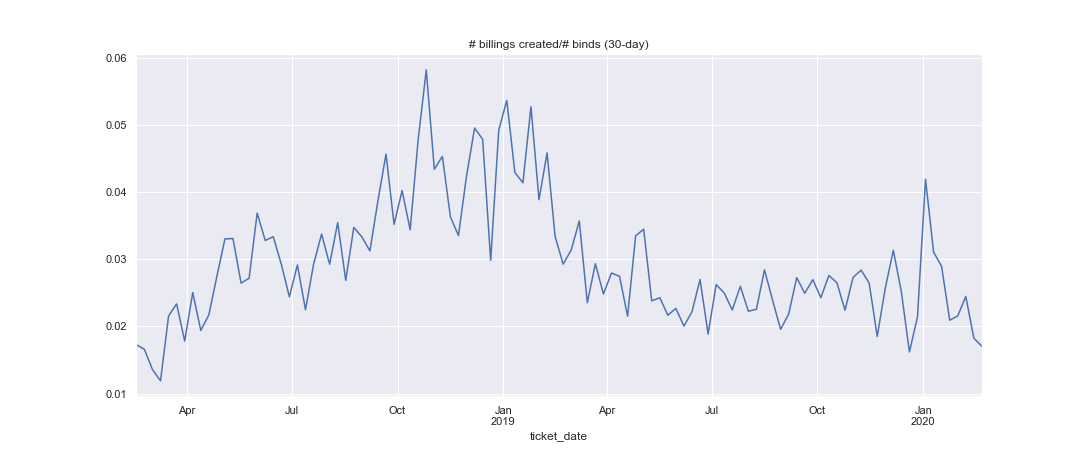

In [835]:
df.set_index('ticket_date').resample('7d').mean()['tickets_over_binds30'].plot(title='# billings created/# binds (30-day)')

In [820]:
list(zip(['t','4'], ['t','4']))

[('t', 't'), ('4', '4')]

In [796]:
test = pd.read_csv('test_locs.csv')

In [798]:
test.to_dict()

{'Unnamed: 0': {0: 0},
 'state': {0: 'NM'},
 'tivbin': {0: '[100001.0, 125001.0)'},
 'occupancy': {0: 'habo10'},
 'location_number': {0: 1},
 'building_number': {0: 1},
 'zip': {0: 48104},
 'iso_construction_code': {0: 'F'},
 'sprinkler': {0: 0},
 'num_units': {0: 25},
 'building_age_years': {0: 21},
 'square_footage': {0: 2345},
 'number_of_stories': {0: 3},
 'tenant_cat_credit_and_bank_cards_heavy_credit_card_usage_very_unlikely_mean': {0: 0.0},
 'tenant_num_balance_all_credit_accts_foreclosure_accts_p50': {0: 0.0},
 'tenant_num_balance_non_mortgage_loan_accts_60_dpd_p50': {0: 1236.0},
 'tenant_num_balance_all_credit_accts_60_to_89_dpd_p50': {0: 0.0},
 'tenant_num_income360_p50': {0: 88215.0},
 'ppc': {0: '4/8B'},
 'crime_index': {0: 10},
 'number_of_baths': {0: 10},
 'number_of_rooms': {0: 50},
 'air_conditioning_single_room': {0: 1},
 'tiv_building': {0: 123456},
 'tiv_contents': {0: 123455},
 'tiv_te': {0: 123454},
 'tiv_autofac': {0: 0.0},
 'autofac_pm_rt': {0: 0.0},
 'limit': {0

A. Disaster Exposure,base,lol
A. Disaster Exposure,base,coinsrel_ct
A. Disaster Exposure,base,coinsrel_te
A. Disaster Exposure,base,coinsrel
B. Climatic Hazards,base,scsrel
B. Climatic Hazards,base,baserate

In [800]:
df = pd.DataFrame({'overall_lol': {'building_1': 1.0965, 'building_2': 1.0965},
                   'overall_coinsrel_ct': {'building_1': 1.0965, 'building_2': 1.0965},
                   'overall_coinsrel_te': {'building_1': 1.0965, 'building_2': 1.0965}, 
                   'overall_coinsrel': {'building_1': 1.0965, 'building_2': 1.0965}, 
                   'overall_scsrel': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_baserate': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_balance_all_credit_accts_foreclosure_accts_p50_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_balance_all_credit_accts_60_to_89_dpd_p50_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_income360_p50_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_cat_credit_and_bank_cards_heavy_credit_card_usage_very_unlikely_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_liens_totaltype_fe_p97_5_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_liens_totaltype_fr_p50_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_balance_non_mortgage_loan_accts_60_dpd_p50_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_tenant_num_basic_demographics_length_of_residence_p50_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_sprinklerrel': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_ppcrel': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_crime_index_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_building_age_years_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_constbg1_bd': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_clean_stories_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_constbg2_bd': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_constbg2_ct': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_constbg1_ct': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_clean_baths_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_clean_square_footage_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_clean_rooms_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_air_conditioning_single_room_mean': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrte_fctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrct_sclfctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrct_bg2fctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrbd_sclfctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrbd_bg2fctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrbd_bg1fctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lyrct_bg1fctr': {'building_1': 1.0965, 'building_2': 1.0965}, 'overall_lol_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lol_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_coinsrel_ct_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_coinsrel_ct_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_coinsrel_te_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_coinsrel_te_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_coinsrel_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_coinsrel_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_scsrel_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_scsrel_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_baserate_deficiency_points': {'building_1': -4796.0, 'building_2': -4796.0}, 'overall_baserate_rate': {'building_1': -8.901001973873676, 'building_2': -8.901001973873676}, 'overall_tenant_num_balance_all_credit_accts_foreclosure_accts_p50_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_num_balance_all_credit_accts_foreclosure_accts_p50_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_num_balance_all_credit_accts_60_to_89_dpd_p50_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_num_balance_all_credit_accts_60_to_89_dpd_p50_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_num_income360_p50_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_num_income360_p50_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_cat_credit_and_bank_cards_heavy_credit_card_usage_very_unlikely_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_cat_credit_and_bank_cards_heavy_credit_card_usage_very_unlikely_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_num_liens_totaltype_fe_p97_5_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_num_liens_totaltype_fe_p97_5_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_num_liens_totaltype_fr_p50_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0},
    'overall_tenant_num_liens_totaltype_fr_p50_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_num_balance_non_mortgage_loan_accts_60_dpd_p50_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_num_balance_non_mortgage_loan_accts_60_dpd_p50_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_tenant_num_basic_demographics_length_of_residence_p50_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_tenant_num_basic_demographics_length_of_residence_p50_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_sprinklerrel_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_sprinklerrel_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_ppcrel_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_ppcrel_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_crime_index_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_crime_index_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_building_age_years_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_building_age_years_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_constbg1_bd_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_constbg1_bd_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_clean_stories_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_clean_stories_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_constbg2_bd_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_constbg2_bd_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_constbg2_ct_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_constbg2_ct_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_constbg1_ct_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_constbg1_ct_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_clean_baths_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_clean_baths_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_clean_square_footage_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_clean_square_footage_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_clean_rooms_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_clean_rooms_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_air_conditioning_single_room_mean_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_air_conditioning_single_room_mean_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrte_fctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrte_fctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrct_sclfctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrct_sclfctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrct_bg2fctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrct_bg2fctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrbd_sclfctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrbd_sclfctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrbd_bg2fctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrbd_bg2fctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrbd_bg1fctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrbd_bg1fctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'overall_lyrct_bg1fctr_deficiency_points': {'building_1': 200.0, 'building_2': 200.0}, 'overall_lyrct_bg1fctr_rate': {'building_1': 0.9656957141300889, 'building_2': 0.9656957141300889}, 'A': {'building_1': 800.0, 'building_2': 800.0}, 'B': {'building_1': -4596.0, 'building_2': -4596.0}, 'C': {'building_1': 1600.0, 'building_2': 1600.0}, 'D': {'building_1': 200.0, 'building_2': 200.0}, 'E': {'building_1': 200.0, 'building_2': 200.0}, 'F': {'building_1': 200.0, 'building_2': 200.0}, 'G': {'building_1': 1200.0, 'building_2': 1200.0}, 'H': {'building_1': 800.0, 'building_2': 800.0}, 'I': {'building_1': 0, 'building_2': 0}, 'J': {'building_1': 0, 'building_2': 0}, 'K': {'building_1': 0, 'building_2': 0}, 'L': {'building_1': 0, 'building_2': 0}, 'M': {'building_1': 0, 'building_2': 0}, 'N': {'building_1': 1400.0, 'building_2': 1400.0}, 'O': {'building_1': 0, 'building_2': 0}, 'P': {'building_1': 0, 'building_2': 0}, 
                   'Q': {'building_1': 0, 'building_2': 0}})

In [819]:
df

overall_lol  overall_coinsrel_ct  overall_coinsrel_te  \
building_1       1.0965               1.0965               1.0965   
building_2       1.0965               1.0965               1.0965   

            overall_coinsrel  overall_scsrel  overall_baserate  \
building_1            1.0965          1.0965            1.0965   
building_2            1.0965          1.0965            1.0965   

            overall_tenant_num_balance_all_credit_accts_foreclosure_accts_p50_mean  \
building_1                                             1.0965                        
building_2                                             1.0965                        

            overall_tenant_num_balance_all_credit_accts_60_to_89_dpd_p50_mean  \
building_1                                             1.0965                   
building_2                                             1.0965                   

            overall_tenant_num_income360_p50_mean  \
building_1                                 1.0965   
building_2                                 1.0965   

            overall_tenant_cat_credit_and_bank_cards_heavy_credit_card_usage_very_unlikely_mean  \
building_1                                             1.0965                                     
building_2                                             1.0965                                     

            ...      H  I  J  K  L  M       N  O  P  Q  
building_1  ...  800.0  0  0  0  0  0  1400.0  0  0  0  
building_2  ...  800.0  0  0  0  0  0  1400.0  0  0  0  

[2 rows x 119 columns]

In [811]:
df.filter(regex='_deficiency_points').iloc[0].sum()

1804.0

In [812]:
df.filter(regex='_deficiency_points').iloc[0]

overall_lol_deficiency_points                                                                             200.0
overall_coinsrel_ct_deficiency_points                                                                     200.0
overall_coinsrel_te_deficiency_points                                                                     200.0
overall_coinsrel_deficiency_points                                                                        200.0
overall_scsrel_deficiency_points                                                                          200.0
overall_baserate_deficiency_points                                                                      -4796.0
overall_tenant_num_balance_all_credit_accts_foreclosure_accts_p50_mean_deficiency_points                  200.0
overall_tenant_num_balance_all_credit_accts_60_to_89_dpd_p50_mean_deficiency_points                       200.0
overall_tenant_num_income360_p50_mean_deficiency_points                                                 

In [818]:
df.loc[:,'A':].iloc[0]

A     800.0
B   -4596.0
C    1600.0
D     200.0
E     200.0
F     200.0
G    1200.0
H     800.0
I       0.0
J       0.0
K       0.0
L       0.0
M       0.0
N    1400.0
O       0.0
P       0.0
Q       0.0
Name: building_1, dtype: float64